<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_02/simple_example_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - classifying digits from the MNIST dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb

MNIST dataset is a dataset of handwritten digits. It contains a training set of 60000 greyscale 28x28 images and a testing set of 10000 images of digits written by different people.

https://yann.lecun.com/exdb/mnist/
https://en.wikipedia.org/wiki/MNIST_database

## Load and preprocess the data
- when training CNNs, we don't need the input patterns to be flatten vectors, 3D tensors are OK 

In [6]:
# Load the MNIST dataset
import keras
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 1. Reshape and normalize the data:
# reshape the data into 4D tensors (54000x28x28x1) and normalize them to the range [0, 1]
x_train = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = train_labels
y_test = test_labels
print(x_train.shape, y_train.shape)


# 2. Arbitrary: one-hot encode the labels:
# For example, the label 3 would become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
y_train_categorical = keras.utils.to_categorical(train_labels, num_classes=10)
y_test_categorical  = keras.utils.to_categorical(train_labels, num_classes=10)

print(y_train_categorical.shape)
print(y_train[:3])
print(y_train_categorical[:3])

# 4. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)



(60000, 28, 28, 1) (60000,)
(60000, 10)
[5 0 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [10]:
# Alternative data normalization: standard scaling to center the data around zero and achieve a unit standard deviation

from sklearn.preprocessing import StandardScaler
import numpy as np

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_s = scaler.fit_transform(x_train.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)

# Transform the test data using the same scaler
x_test_s = scaler.transform(x_test.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)

# Mean and standard deviation for the two variants of normalization:
print(np.mean(x_train_s), np.std(x_train_s), np.mean(x_test_s), np.std(x_test_s))
print(np.mean(x_train), np.std(x_train), np.mean(x_test), np.std(x_test))

-1.8770732e-09 0.9549811 0.0025694391 1.0056078
0.13067737 0.30813214 0.13251467 0.31048027


## Define and train the model

### Simple CNN model for multiclass classification:
- Start with a keras.Input layer specifying the input shape.
- Add multiple blocks of Conv2D (with 'relu' activation) followed by MaxPooling2D.
- Then add a Flatten layer to convert 2D feature maps to 1D.
- Include one or more Dense layers with 'relu' (or 'tanh') activations for feature extraction.
- Use 'softmax' activation function in the output layer for multiclass classification.

- Loss function and metrics based on label encoding:
    - If labels are one-hot vectors, use `CategoricalCrossentropy` as the loss function and `CategoricalAccuracy` as the metric.
    - If labels are provided as integers, use `SparseCategoricalCrossentropy` as the loss function and `SparseCategoricalAccuracy` as the metric.




In [14]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "mnist_cnn_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_mnist/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax') 
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),   # SGD, Adam, RMSProp     
              loss= keras.losses.SparseCategoricalCrossentropy(),                
              metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")]) 

num_epochs = 5
batch_size = 128

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"
# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
model_name = model_dir + model_datetime_name + ".keras"
model.save(model_name)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.8518 - loss: 0.5024 - val_accuracy: 0.9808 - val_loss: 0.0659
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9816 - loss: 0.0597 - val_accuracy: 0.9848 - val_loss: 0.0506
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9870 - loss: 0.0411 - val_accuracy: 0.9878 - val_loss: 0.0421
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9904 - loss: 0.0297 - val_accuracy: 0.9860 - val_loss: 0.0452
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9932 - loss: 0.0213 - val_accuracy: 0.9900 - val_loss: 0.0376
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9880 - loss: 0.0415
Test accuracy: 0.9904000163078308 
Test loss: 0.03323046490550041


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


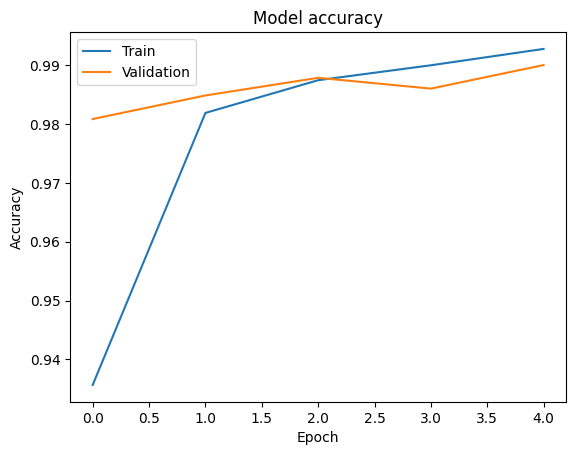

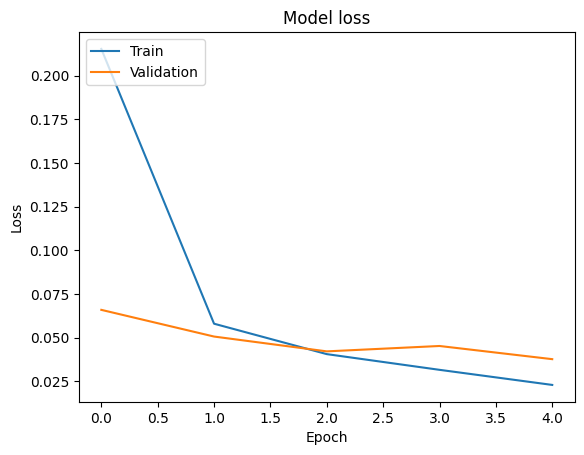

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9951 - loss: 0.0171
Training accuracy: 0.9952592849731445 
Train loss: 0.016350742429494858
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9904 - loss: 0.0362
Validation accuracy: 0.9900000095367432 
Val loss: 0.037616148591041565
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9880 - loss: 0.0415
Test accuracy: 0.9904000163078308 
Test loss: 0.03323046490550041


In [18]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[5.7034395e-09 1.2303307e-08 1.5014327e-06 7.7863639e-08 6.7346648e-09
 4.7035219e-11 8.1009257e-15 9.9999833e-01 1.0877697e-08 4.2502492e-08]
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
True labels: [7 2 1 0 4 1 4 9 5 9]
Number of misclassified images: 96 out of 10000 , accuracy 0.9904000163078308


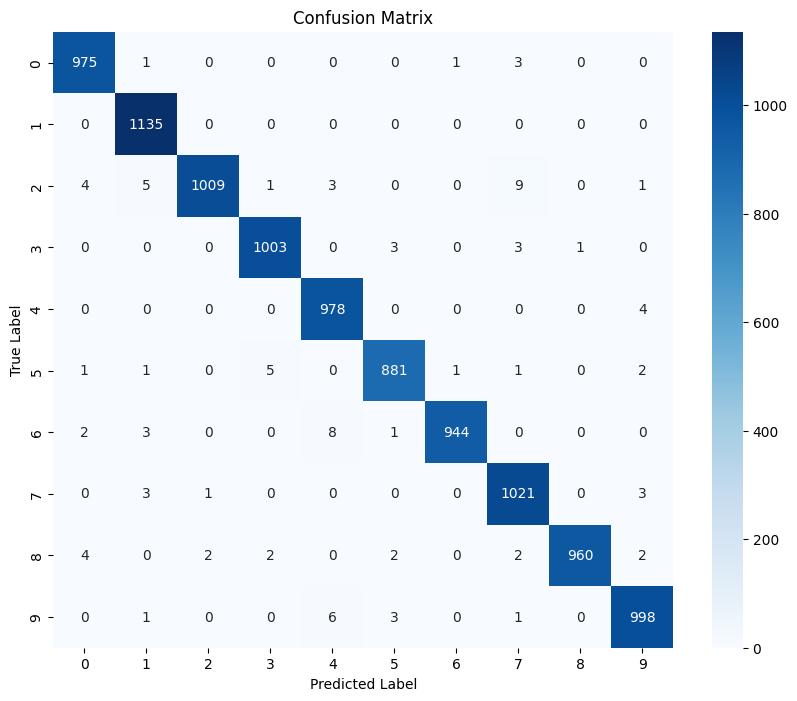

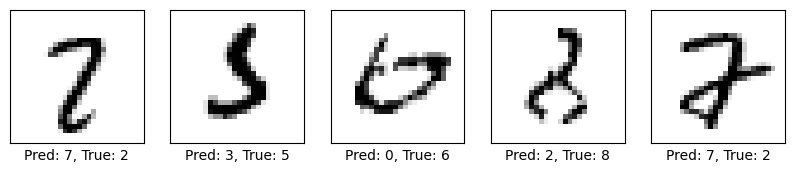

In [16]:
# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)
print(y_pred_probs[0])

# Get the predicted class for each sample
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predicted labels:", y_pred[:10])
print("True labels:", y_test[:10])

# Misclassified indices:
misclassified_indices = np.where(y_pred != y_test)[0]
num_misclassified = len(misclassified_indices)
print("Number of misclassified images:", num_misclassified, 
      "out of", len(y_test), ", accuracy", test_acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot some misclassified images
num_images_to_plot = 5
plt.figure(figsize=(10, 10))
for i in range(min(num_images_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {y_pred[index]}, True: {y_test[index]}")
plt.show()

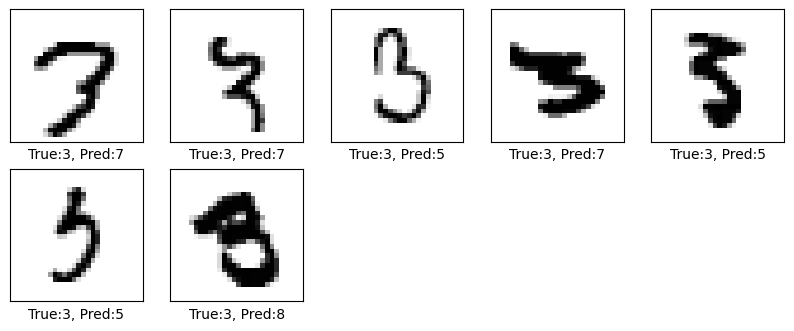

In [17]:
# Plot some misclassified images from a given target (or predicted) class
target_class = 3
misclassified_indices_class = np.where((y_pred != y_test) & (y_test == target_class))[0]
#misclassified_indices_class = np.where((y_pred != y_test) & (y_pred == target_class))[0]



# Display the first 25 misclassified images for the target class
plt.figure(figsize=(10, 10))
for i in range(min(25, len(misclassified_indices_class))):
    index = misclassified_indices_class[i]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"True:{y_test[index]}, Pred:{y_pred[index]}")
plt.show()


# Exercises
1. **Compare the results with MLP** (see multiclass_classification_mnist.ipynb). In both cases, use the same optimizer (e.g., Adam) and appropriate number of epochs.  
2. **Experiment with the architecture**. For example, use only one convolutional block with additional dense layers. Experiment with kernel sizes and the number of filters.

# More exercises
1. Experiment with the number of epochs and batch size.
2. Change the optimizer of the model.
3. Try standardization of the data instead of simple normalization to [0, 1].
4. Use one-hot encoding of the output data with `CategoricalCrossentropy` as the loss function.



In [19]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_mnist --reload_interval=1

Reusing TensorBoard on port 6006 (pid 4864), started 0:22:18 ago. (Use '!kill 4864' to kill it.)